# GTEx PLIER exploratory analyses

Marc Subirana-Granés (2024)

Pathway Level Information ExtractoR (PLIER) (Mao, et al. bioRxiv. 2017.) is a framework that explicitly aligns latent variables (LVs) with prior knowledge in the form of (often curated) gene sets. Comparisons of PLIER to other methods (e.g., sparse PCA) and other evaluations can be found in the PLIER preprint.

We’re going to explore the GTEx dataset and the corresponding PLIER model. 

## Settings and paths

In [1]:
INPUT_PLIER_MODEL_FILE = NULL 

In [2]:
# Parameters
INPUT_PLIER_MODEL_FILE = "output/gtex/plier_result_k1_frac0.7.rds"


## Load libraries and data

In [3]:
suppressPackageStartupMessages({
    
    library(PLIER)
    library(ggplot2)
    library(assertthat)
    library(dplyr)
    
})
source(here::here('scripts/plier_util.R'))

In [4]:
assert_that(!is.null(INPUT_PLIER_MODEL_FILE), msg = "Input PLIER model was not specified")
INPUT_PLIER_MODEL_FILE=here::here(INPUT_PLIER_MODEL_FILE)

[1] TRUE

In [5]:
gtex_plier_results=readRDS(here::here(INPUT_PLIER_MODEL_FILE))
num_lvs <- nrow(gtex_plier_results$B)
matrixU <- gtex_plier_results$U
matrixZ <- gtex_plier_results$Z
matrixB <- gtex_plier_results$B

## Matrix Z (loadings; gene x LVs)

The Z matrix captures the association strength between each LV and the genes across the dataset. In essence, each column of Z corresponds to an LV, and each row to a gene. The value at a given position (i,j) within Z indicates the contribution or importance of gene i to LV j. High absolute values suggest a strong association between a gene and an LV, indicating that the gene's expression patterns are significantly represented by that LV.

In [6]:
head(matrixZ)
dim(matrixZ)

GAS6,0.00000000,0.0000000,0.509601923,0.02303278,0.000000000,0.047740572,0.00000000,0.000000000,0.437047051,0.1329501,⋯,0.0000000,0.00000000,0.000000000,0.0000000,0.0000000,0.02756796,0,0.0464884923,0.00000000,0.37930827
MMP14,0.00000000,0.0000000,0.000000000,0.08079764,0.000000000,0.000000000,0.00000000,0.000000000,0.628765339,0.0000000,⋯,0.0000000,0.05210891,0.060536933,0.0000000,0.0000000,0.00000000,0,0.0000000000,0.00000000,0.37263566
MARCKSL1,0.02950483,0.0000000,0.005777573,0.00000000,0.000000000,0.059612700,0.00000000,0.000000000,0.004135659,0.0000000,⋯,0.1121266,0.00000000,0.000000000,0.0000000,0.0000000,0.01177523,0,0.0009735427,0.03060058,0.03408577
SPARC,0.00000000,0.0000000,0.000000000,0.03919136,0.000000000,0.000000000,0.00000000,0.040459910,0.277030056,0.3893688,⋯,0.0000000,0.00000000,0.000000000,0.0000000,0.0553349,0.26913268,0,0.0385386762,0.00000000,0.03187780
CTSD,0.00000000,0.1542023,0.688261428,0.08714279,0.000000000,0.008311279,0.00000000,0.167463435,1.852126115,0.1398464,⋯,0.0000000,0.05531637,0.004370088,0.0000000,0.0000000,0.00000000,0,0.0000000000,0.09982121,0.57563089
EPAS1,0.00000000,0.0000000,0.000000000,0.00000000,0.008342559,0.035922995,0.05970857,0.008032573,0.178316151,0.0212524,⋯,0.0000000,0.00000000,0.000000000,0.0902047,0.4519502,0.00000000,0,0.0471251644,0.00000000,0.15490261


[1] 6683 1042

## Matrix B (loadings; LV x samples)
Matrix B represents the association LVs and the samples in the gene expression dataset.

In [7]:
head(matrixB)
dim(matrixB)

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
"1,IRIS_Neutrophil-Resting",0.002535341,-0.04370579,0.008896618,-0.040861327,0.01004205,-0.04501671,-0.02085150,0.008406361,-0.01470911,0.015219110,⋯,0.003852116,-0.02826184,-0.013730186,0.029131151,0.008022848,0.03222826,0.039309007,-0.02315738,0.0309807534,-0.062869901
"2,IRIS_Neutrophil-Resting",-0.036216704,-0.04205619,0.015346513,-0.032393481,-0.03428301,-0.02622960,-0.02392661,-0.016633246,-0.01347106,-0.080844631,⋯,-0.014479596,0.01169663,0.003722825,-0.006459869,0.015024403,-0.01393061,0.032931211,-0.01396817,-0.0127770805,0.004344517
"3,REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES",-0.049782191,-0.02805278,0.056003293,0.072123311,0.05526153,-0.05390967,-0.01613316,0.007187259,-0.04157486,0.004774956,⋯,0.012666339,0.00012085,-0.065989568,0.034201192,-0.032211689,0.04401801,0.001256358,0.15114167,-0.0008082211,0.004330334
"4,REACTOME_DNA_STRAND_ELONGATION",-0.070034949,-0.03354618,-0.105972428,-0.108746841,-0.04998180,-0.10285130,-0.07395319,0.099978788,-0.03305152,-0.068522377,⋯,-0.034011051,-0.05845505,-0.063836002,-0.021872189,-0.085122302,-0.01726072,0.369542669,-0.13096173,-0.0275255871,-0.062070072
"5,REACTOME_NEURONAL_SYSTEM",0.050598296,-0.01247532,0.030158286,0.001910724,-0.02141408,-0.01023089,-0.02101647,-0.009126819,-0.01752155,-0.028291885,⋯,-0.035831201,-0.05187064,0.020248505,-0.002611368,-0.019189933,-0.04118643,0.012926796,0.03096042,-0.0611740629,0.007897079
"6,REACTOME_CELL_CYCLE_CHECKPOINTS",-0.076088528,-0.05600864,-0.114322889,-0.011100703,-0.06032094,-0.06958746,-0.02193094,-0.057255665,-0.03764977,-0.021212990,⋯,-0.042958319,-0.01293398,-0.064663867,-0.025796319,-0.027538524,-0.11030715,-0.031614062,-0.03923539,-0.0570118731,-0.022636503


[1]  1042 17382

## Matrix U (loadings; pathway x LVs)

The matrix U links LVs, derived from gene expression data, to prior biological knowledge encapsulated in gene sets or pathways. Each element in 
U quantifies the association between a specific pathway and an LV. 

In [8]:
head(matrixU)
dim(matrixU)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV1033,LV1034,LV1035,LV1036,LV1037,LV1038,LV1039,LV1040,LV1041,LV1042
IRIS_Bcell-Memory_IgG_IgA,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-Memory_IgM,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-naive,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-N0,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated12hour,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated48hour,0,0,0,0.2299679,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1]  628 1042

## Summary of LV and coverage
If the prior information coefficient matrix, U, has a low number of positive entries for each LV, biological interpretation should be more straightforward. This is one of the constraints in the PLIER model.

### All LVs
For each latent variable (i.e., not just those significantly associated with prior information), how many of the pathways/genesets have a positive entry?

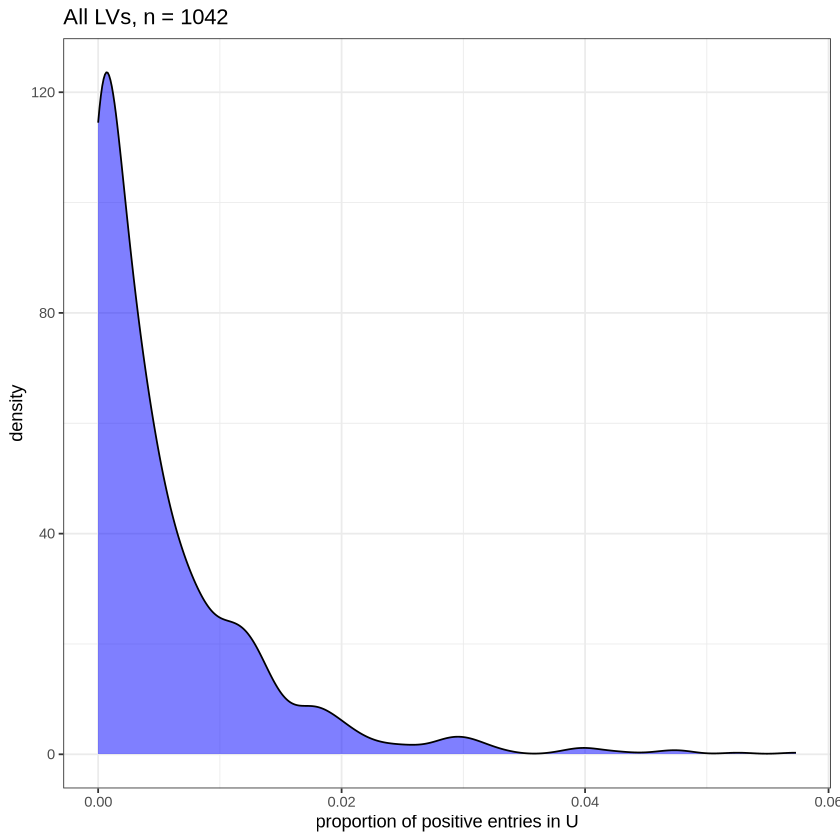

In [9]:
num_lvs <- nrow(matrixB)

u_sparsity_all <- CalculateUSparsity(plier.results = gtex_plier_results,
                                     significant.only = FALSE)
ggplot2::ggplot(as.data.frame(u_sparsity_all),
                ggplot2::aes(x = u_sparsity_all)) +
  ggplot2::geom_density(fill = "blue", alpha = 0.5) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "proportion of positive entries in U") +
  ggplot2::ggtitle(paste("All LVs, n =", num_lvs))

In [10]:
summary(u_sparsity_all)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.003185 0.005460 0.007962 0.057325 

### Significant pathways, only
What proportion of entries in the U matrix for each LV are significantly associated with that LV?

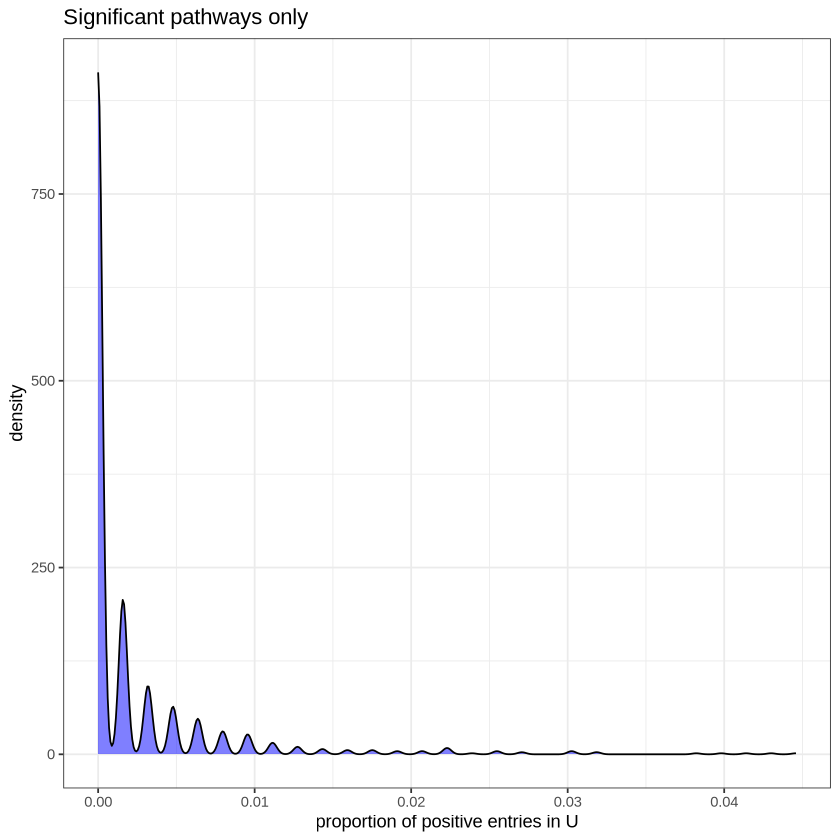

In [11]:
u_sparsity_sig <- CalculateUSparsity(gtex_plier_results, 
                                     significant.only = TRUE,
                                     fdr.cutoff = 0.05)
ggplot2::ggplot(as.data.frame(u_sparsity_sig),
                ggplot2::aes(x = u_sparsity_sig)) +
  ggplot2::geom_density(fill = "blue", alpha = 0.5) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "proportion of positive entries in U") +
  ggplot2::ggtitle("Significant pathways only")

In [12]:
summary(u_sparsity_sig)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.002317 0.001592 0.044586 

### Pathway coverage
<!-- We’re interested in how the LVs output from PLIER are related to the genesets input to PLIER. -->

In [13]:
coverage_results <- GetPathwayCoverage(plier.results = gtex_plier_results)

What proportion of the pathways input into PLIER are significantly associated (FDR cutoff = 0.05) with LVs?

In [14]:
round(coverage_results$pathway, 3)

[1] 0.561

What proportion of the PLIER LVs have a gene set associated with them?

In [15]:
round(coverage_results$lv, 3)

[1] 0.374

## Reconstruction of gene expression data
The "reconstructed" expression data comes form the producto of PLIER gene expression loadings(matrix Z) and latent variables (matrix B)

### All LVs
We reconstruct gene expression data from the gene loadings and LVs.

In [16]:
# reconstructed GTEx expression data from PLIER model
recount_recon <- GetReconstructedExprs(z.matrix = as.matrix(matrixZ),
                                       b.matrix = as.matrix(matrixB))


In [17]:
# TODO:input expression data from intermediate file

# Load GTEx data
gtex_expression_path=here::here('output/gtex/GTEx_v8_gene_median_tpm.rds')
gtex_expression_data <- readRDS(gtex_expression_path)

# Remove gene ens id column and duplicate genes
gtex_expression_data <- subset(gtex_expression_data, select = -c(gene_ens_id))
gtex_expression_data <- gtex_expression_data[!duplicated(gtex_expression_data["gene_symbol"]),]

# Rename rows with gene symbols
rownames(gtex_expression_data) <- gtex_expression_data[,"gene_symbol"]

# Remove gene symbol column
gtex_expression_data <- subset(gtex_expression_data, select = -c(gene_symbol))

# Remove NA
gtex_expression_data = na.omit(gtex_expression_data)

# Convert to matrix
gtex_expression_matrix <- as.matrix(gtex_expression_data)

# Z-score normalization
recount_input_exprs <- PLIER::rowNorm(gtex_expression_matrix)

### Reconstruction error

The reconstruction of the error is carried out using MASE (mean absolute scaled error) between the two gene expression matrices (before and after the reconstruction).

In [18]:
# reorder rows and columns equal
row_order <- rownames(recount_recon)
col_order <- colnames(recount_recon)
recount_input_exprs <- recount_input_exprs[row_order, col_order]

# calculate reconstruction error (per sample)
recon_error <- GetReconstructionMASE(true.mat = recount_input_exprs, 
                                     recon.mat = recount_recon)

# get number of LVs
num_lvs <- nrow(matrixB)

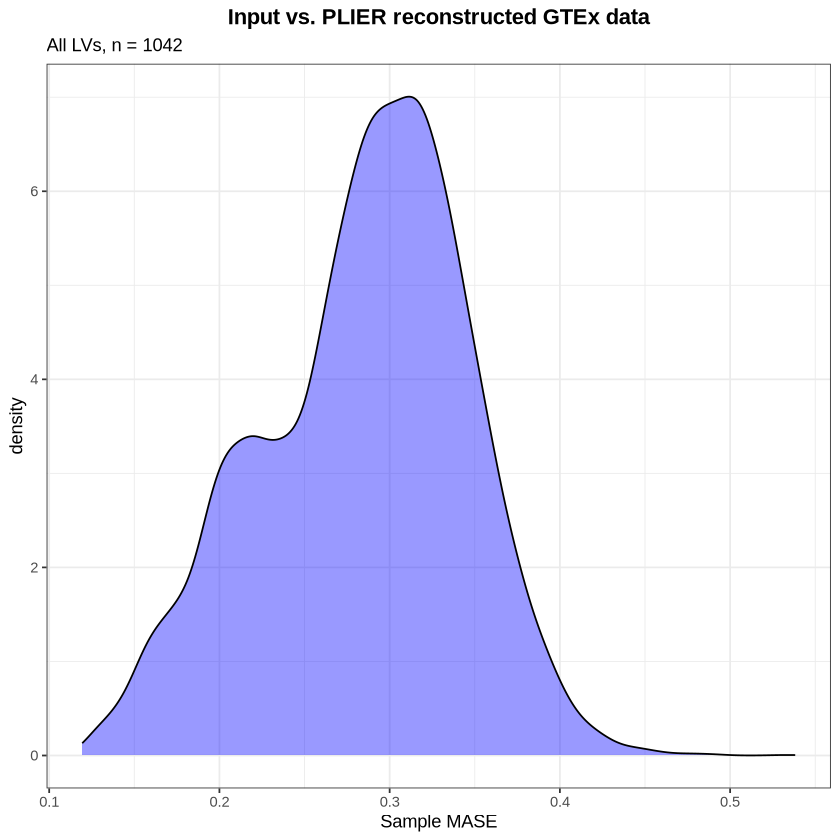

In [19]:
# density plot
ggplot2::ggplot(as.data.frame(recon_error), ggplot2::aes(x = recon_error)) + 
  ggplot2::geom_density(fill = "blue", alpha = 0.4) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "Sample MASE",
                title = "Input vs. PLIER reconstructed GTEx data",
                subtitle = paste("All LVs, n =", num_lvs)) +
  ggplot2::theme(plot.title = ggplot2::element_text(hjust = 0.5, face = "bold"))

### Spearman correlation (input, reconstructed)
If correlation between the input and the reconstructed data is high, that suggests that reconstruction is “successful.” Given the different constraints in PLIER, we would not expect to perfectly (rho = 1) reconstruct the input data. This particular evaluation will be most useful when we look at applying a trained PLIER model to a test dataset.

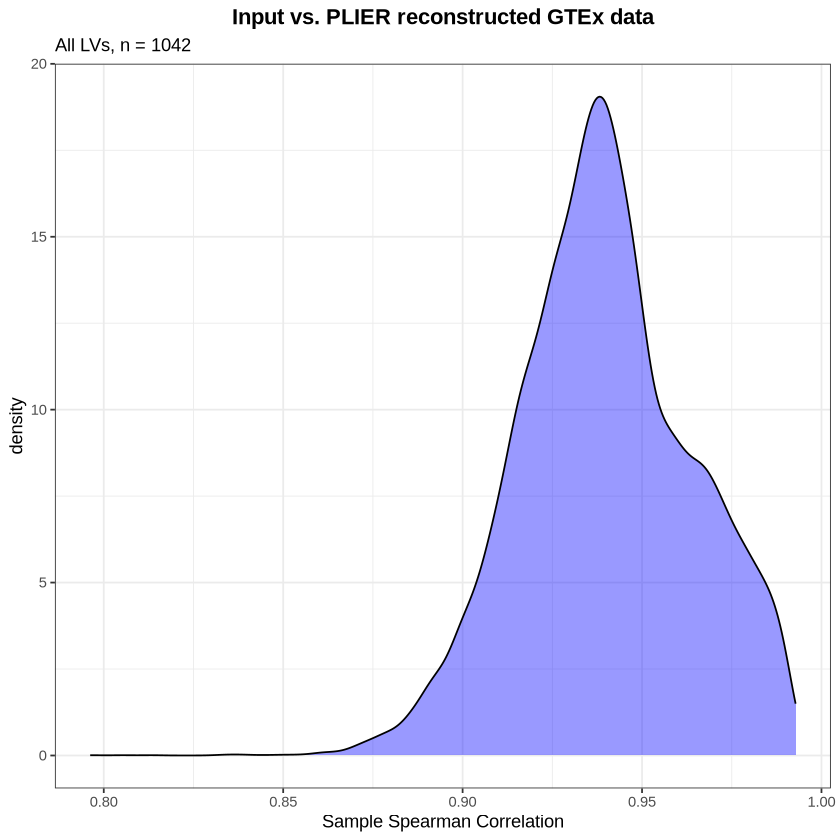

In [20]:
# calculate correlation 
recon_cor <- GetReconstructionCorrelation(true.mat = recount_input_exprs,
                                          recon.mat = recount_recon)
# density plot
ggplot2::ggplot(as.data.frame(recon_cor), ggplot2::aes(x = recon_cor)) + 
  ggplot2::geom_density(fill = "blue", alpha = 0.4) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "Sample Spearman Correlation",
                title = "Input vs. PLIER reconstructed GTEx data",
                subtitle = paste("All LVs, n =", num_lvs)) +
  ggplot2::theme(plot.title = ggplot2::element_text(hjust = 0.5, face = "bold"))

### Relationship between error and correlation


We expect that samples that are highly correlated pre- and post-PLIER should have low MASE.

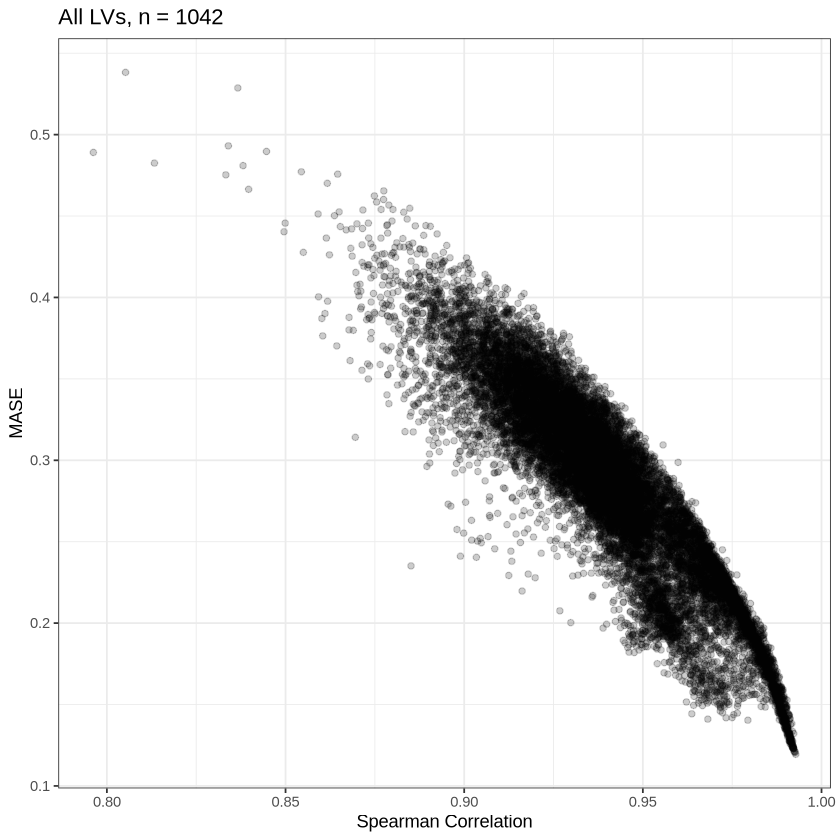

In [21]:
ggplot2::ggplot(as.data.frame(cbind(recon_cor, recon_error)), 
                ggplot2::aes(x = recon_cor,
                             y = recon_error)) +
  ggplot2::geom_point(alpha = 0.2) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "Spearman Correlation",
                y = "MASE",
                title = paste("All LVs, n =", num_lvs))